<a href="https://colab.research.google.com/github/JustiinFrancisco/CSCI218_Project_Group37/blob/Main-Code/CSCI218_Project_Group37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Spam Email Detection (Group 37)

## Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
import os
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

## Load Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CSCI218/spam_ham_dataset.csv")

In [ ]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
df.columns

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


## Data Preprocessing

**Check for NULL values**

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
label,0
text,0
label_num,0


**Remove duplicates**

In [ ]:
df.drop_duplicates(inplace = True)

**Remove insignificant columns**

In [ ]:
Columns = ["Unnamed: 0", "label_num"]
df.drop(columns = Columns, axis = 1, inplace = True)

In [ ]:
df.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


**Dimensions of the Dataset**

In [ ]:
df.shape

(5171, 2)

**Checking for the classes in the Data**

In [ ]:
df.groupby("label").count()

,text
label,
ham,3672
spam,1499


**Percentage of Ham vs Spam**

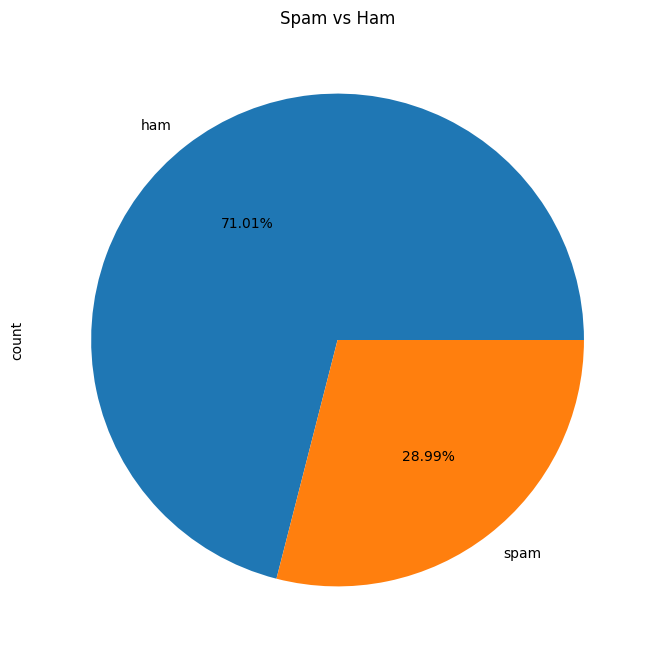

In [ ]:
df["label"].value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
plt.title("Spam vs Ham", loc = "center")
plt.show()

## Text Preprocessing

**Before processing**

In [ ]:
df['text'][0]

"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

In [ ]:
def text_preprocess(df, text_column='text', label_column='label'):

    # Convert text to lowercase
    df[text_column] = df[text_column].str.lower()

    # Remove "subject:" if it appears at the start of the text
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'^subject:\s*', '', x))

    # Removing special characters except spaces and colons
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'[^\w\s\:]', '', x))

    #Removing carriage returns and newlines
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'\r|\n', '', x))

    # Removing numbers
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'\d+', '', x))

    # Removing extra spaces
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

    # Remove short words
    df[text_column] = df[text_column].apply(lambda x: " ".join([word for word in x.split() if len(word) > 2]))

    # Encode labels
    le = LabelEncoder()
    df[label_column] = le.fit_transform(df[label_column])

    return df

In [ ]:
df = text_preprocess(df)

**After processing**

In [ ]:
df['text'][0]

'enron methanol meter this follow the note gave you monday preliminaryflow data provided daren please override pop daily volume presently zero reflect dailyactivity you can obtain from gas control this change needed asap for economics purposes'

In [ ]:
df.head()

,label,text
0,0,enron methanol meter this follow the note gave...
1,0,hpl nom for january see attached file hplnol x...
2,0,neon retreatho around that most wonderful time...
3,1,photoshop windows office cheap main trendingab...
4,0,indian springsthis deal book the teco pvr reve...


Label 0: HAM

Label 1: SPAM

## Feature engineering

  Converts email text into numerical features using TF-IDF or Bag-of-Words.


In [ ]:
def extract_features(df, method="tfidf"):

    if method == "tfidf":
        vectorizer = TfidfVectorizer(stop_words="english", max_features=3000)  # TF-IDF
    else:
        vectorizer = CountVectorizer(stop_words="english", max_features=3000)  # Bag-of-Words

    X = vectorizer.fit_transform(df["text"])  # Convert text to numerical format
    y = np.array(df["label"])  # Convert labels to numpy array

    return X, y, vectorizer  # Returns feature matrix, labels, and vectorizer

Apply Feature Extraction

In [ ]:
# Choose Feature Extraction Method
X, y, vectorizer = extract_features(df, method="tfidf")  # Change to 'bow' for Bag of Words

Print Dataset Summary

In [ ]:
# Check unique values
print("Unique values in 'label' column after correction:", df['label'].unique())

# Print Feature Shape Summary
print(f"Feature Matrix Shape: {X.shape}")  # (num_emails, num_features)
print(f"Spam Percentage: {np.mean(y) * 100:.2f}%")

# Show first 10 words
feature_names = vectorizer.get_feature_names_out()
print(f"Words used as features: {feature_names[:10]}")

Unique values in 'label' column after correction: [0 1]
Feature Matrix Shape: (5171, 3000)
Spam Percentage: 28.99%
Words used as features: ['abdv' 'ability' 'able' 'absolutely' 'accept' 'acceptance' 'accepted'
 'access' 'according' 'accordingly']


**Identify words most indicative of spam**

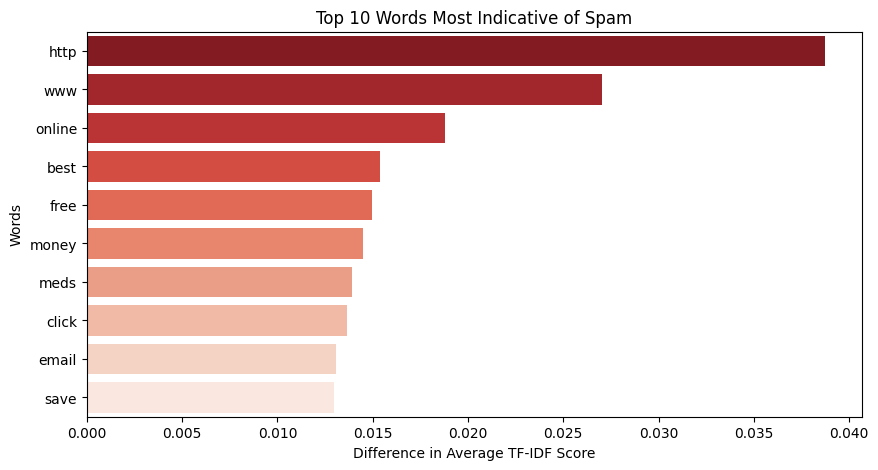

In [ ]:
# Convert sparse matrix to DataFrame
X_df = pd.DataFrame(X.toarray(), columns=feature_names)

spam_indices = np.where(y == 1)[0]  # Indices of spam emails
non_spam_indices = np.where(y == 0)[0]  # Indices of non-spam emails

spam_word_scores = X_df.iloc[spam_indices].mean()  # Avg TF-IDF for spam
non_spam_word_scores = X_df.iloc[non_spam_indices].mean()  # Avg TF-IDF for non-spam

# Find words with the highest difference in spam vs non-spam scores
spam_indicative_words = (spam_word_scores - non_spam_word_scores).sort_values(ascending=False)

# Select top 10 spam-indicative words
top_words = spam_indicative_words.head(10)

# Plot Bar Chart
plt.figure(figsize=(10, 5))
sns.barplot(x=top_words.values, y=top_words.index, hue=top_words.index, legend=False, palette="Reds_r")
plt.xlabel("Difference in Average TF-IDF Score")
plt.ylabel("Words")
plt.title("Top 10 Words Most Indicative of Spam")
plt.show()

## Split the Dataset

In [ ]:
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["label"], random_state=42
) #stratified splitting into 70% train, 30% temp which will be split into validation and test

In [ ]:
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

In [ ]:
train_distribution = train_df["label"].value_counts(normalize=True)
train_distribution.name = "label"
print(train_distribution) #class distribution for training set

label
0    0.710141
1    0.289859
Name: label, dtype: float64


## Handle imbalance

Handling imbalance for training data


In [ ]:
X_train, y_train, vectorizer = extract_features(train_df, method="tfidf")  # Get TF-IDF features for training data

print("Original training set distribution:")
print(pd.Series(y_train).value_counts())

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)  # Oversampling to baalance classes

print("\nAfter oversampling:")
print(pd.Series(y_train_res).value_counts())  #New class distribution

Original training set distribution:
0    2570
1    1049
Name: count, dtype: int64

After oversampling:
0    2570
1    2570
Name: count, dtype: int64


In [ ]:
# Get TF-IDF features for testing data using same vectorizer
X_test = vectorizer.transform(test_df["text"])
y_test = np.array(test_df["label"])

print("Original testing set distribution:")
print(pd.Series(y_test).value_counts())

Original testing set distribution:
0    551
1    225
Name: count, dtype: int64


In [ ]:
# Get TF-IDF features for validation data using same vectorizer
X_val = vectorizer.transform(val_df["text"])
y_val = np.array(val_df["label"])

print("Original validation set distribution:")
print(pd.Series(y_val).value_counts())

Original validation set distribution:
0    551
1    225
Name: count, dtype: int64


## Train ML model



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(random_state=42),
    "Multinomial Naive Bayes": MultinomialNB()
}

# Train each model and evaluate it on the validation set
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_res, y_train_res)

    # Make predictions
    y_val_pred = model.predict(X_val)

    # Evaluate performance
    accuracy = accuracy_score(y_val, y_val_pred)
    class_report = classification_report(y_val, y_val_pred, output_dict=True)

    # Store results
    results[model_name] = {
        "accuracy": accuracy,
        "precision": class_report["macro avg"]["precision"],
        "recall": class_report["macro avg"]["recall"],
        "f1_score": class_report["macro avg"]["f1-score"]
    }

## Evaluate accuracies

In [ ]:
# Display the results for comparison
results_df = pd.DataFrame(results).T
print(results_df)

                         accuracy  precision    recall  f1_score
Random Forest            0.967784   0.952098  0.973370  0.961806
Logistic Regression      0.961340   0.941732  0.971462  0.954653
SVM                      0.976804   0.967499  0.977092  0.972123
Multinomial Naive Bayes  0.923969   0.897987  0.930684  0.911528


## Optimize Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Penalty parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Gamma for non-linear kernels
    'kernel': ['rbf', 'linear'],  # Different types of kernel
}

# Initialize the SVM classifier
svm = SVC(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best Parameters:", best_params)

# Evaluate the model on the test set
y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Test Accuracy with optimized SVM: {test_accuracy * 100:.2f}%")


Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy with optimized SVM: 97.04%


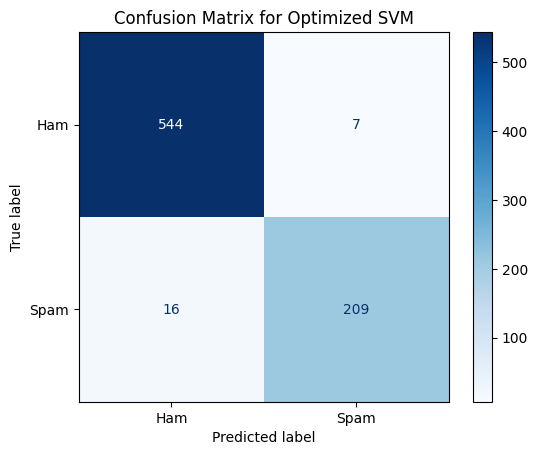

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])  # Adjust labels as needed
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Optimized SVM")
plt.show()


## Testing out some sample email

In [ ]:
# Example emails for classification
new_emails = [
    "Congratulations! You've won a free vacation. Click here to claim your prize.",
    "Urgent: Your bank account has been compromised. Please verify your details immediately.",
    "Hey, are we still on for the meeting at 3 PM tomorrow? Let me know!",
    "Limited-time offer! Buy one, get one free. Click the link now!",
    "Dear Customer, your invoice for this month is attached. Let us know if you have any questions.",
    "You have been selected for a special reward! Click here to redeem now.",
]

# Convert the new email into TF-IDF features using the trained vectorizer
X_new = vectorizer.transform(new_emails)

# Predict the label using the best trained SVM model
predicted_labels = best_model.predict(X_new)

# Output the results
for email, label in zip(new_emails, predicted_labels):
    print(f"Email: {email}\nPredicted Label: {'Spam' if label == 1 else 'Not Spam'}\n")


Email: Congratulations! You've won a free vacation. Click here to claim your prize.
Predicted Label: Spam

Email: Urgent: Your bank account has been compromised. Please verify your details immediately.
Predicted Label: Spam

Email: Hey, are we still on for the meeting at 3 PM tomorrow? Let me know!
Predicted Label: Not Spam

Email: Limited-time offer! Buy one, get one free. Click the link now!
Predicted Label: Spam

Email: Dear Customer, your invoice for this month is attached. Let us know if you have any questions.
Predicted Label: Not Spam

Email: You have been selected for a special reward! Click here to redeem now.
Predicted Label: Spam

